In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('gdrive/My Drive')

In [ ]:
!ls

 17505007_1809645692689489_8626958768252932601_o.jpg
 17620308_1809645539356171_6483840456950114077_o.jpg
 17632210_1809645579356167_6444818044242783780_o.jpg
 17635470_1809645459356179_961910668900561839_o.jpg
 180377_1.pdf
 6428195706.pdf
'(8th Edition) (The Pearson Series in Economics) Robert Pindyck, Daniel Rubinfeld-Microeconomics-Prentice Hall (2012).pdf'
'after MID SEMS'
 balsa
 Balsa_Summer
 Biplane.enc
 Captures
'Case study.gslides'
'CE242A REPORT.gdoc'
 checkpoint
'CHM 101 lab exam sed. 2017.docx'
'CHM101 Practical Copy-1.pdf'
'CHM101 Practical Copy.pdf'
 CHM102_18_19_HA_1.pdf
 CHM102_18_19_HA_2.pdf
'CHM102_18_19_HA_3 (1).pdf'
 CHM102_18_19_HA_3.pdf
 Class_slides_Lec7_sectionB.pdf
 clrs.pdf
'Colab Notebooks'
'Consulting proposal (1).gslides'
'Consulting proposal.gslides'
 convert-jpg-to-pdf.net_2019-05-24_10-36-35.pdf
'Copy of Bevel Gear11.ipt'
'Copy of Bevel Gear22.ipt'
'Copy of Bevel Gears1.iam'
'Copy of Bevel Gears3.iam'
'COST ANALYSIS.gsheet'
 Crack500
 crack_seg_main.zip

In [ ]:
#Nos.chdir('Crack_Segmentation_labelled.zip')

In [ ]:
!ls Crack_Segmentation_Labelled

test  train


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import regularizers
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Reshape,Permute,Activation,Conv2DTranspose,Concatenate,Input
from keras import backend as K
from keras.models import Model
import argparse, glob,os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam 

# Unet Model

In [ ]:


K.set_image_data_format('channels_last')
bn_axis = 3


def conv_block(input_tensor, filters, kernel_size, name, strides, padding='same', dila=1):
    x = Conv2D(filters, kernel_size, strides=strides, name= name, padding=padding, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), dilation_rate=dila)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name='bn_'+ name)(x)
    x = Activation('relu')(x)

    return x

# -----

def Net(input_shape = (224,224,3)):
    inputs = Input(input_shape)
    # ---------left branch -----
    x = conv_block(inputs, 32, (3, 3), strides=1, name='L_conv1-1')
    L1 = conv_block(x, 32, (3, 3), strides=1, name='L_conv1-2')
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(L1)
    #   224 -> 112

    x  = conv_block(x, 64, (3, 3), strides=1, name='L_conv2-1')
    L2 = conv_block(x, 64, (3, 3), strides=1, name='L_conv2-2')
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(L2)
    #   112 -> 56

    x  = conv_block(x, 128, (3, 3), strides=1, name='L_conv3-1')
    L3 = conv_block(x, 128, (3, 3), strides=1, name='L_conv3-2')
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(L3)
    #   56 -> 28

    x  = conv_block(x, 256, (3, 3), strides=1, name='L_conv4-1')
    L4 = conv_block(x, 256, (3, 3), strides=1, name='L_conv4-2')
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(L4)
    #   28 -> 14

    x = conv_block(x, 512, (3, 3), strides=1, name='L_conv5-1')
    x = conv_block(x, 512, (3, 3), strides=1, name='L_conv5-2')
    x = conv_block(x, 512, (3, 3), strides=1, name='L_conv5-3')
    #    14

    # ---------Right branch -----
    #   14 -> 28
    x = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',name='R_conv1-1')(x)
    x = BatchNormalization(axis=bn_axis, name='R_conv1-1_' + 'bn')(x)
    x = conv_block(Concatenate(axis=-1)([x, L4]), 256, (3, 3), strides=1, name='R_conv1-2')
    x = conv_block(x, 256, (3, 3), strides=1, name='R_conv1-3')


    #   28 -> 56
    x = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', name='R_conv2-1')(x)
    x = BatchNormalization(axis=bn_axis, name='R_conv2-1_' + 'bn')(x)
    x = conv_block(Concatenate(axis=-1)([x, L3]), 128, (3, 3), strides=1, name='R_conv2-2')
    x = conv_block(x, 128, (3, 3), strides=1, name='R_conv2-3')


    #   56 -> 112
    x = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', name='R_conv3-1')(x)
    x = BatchNormalization(axis=bn_axis, name='R_conv3-1_' + 'bn')(x)
    x = conv_block(Concatenate(axis=-1)([x, L2]), 64, (3, 3), strides=1, name='R_conv3-2')
    x = conv_block(x, 64, (3, 3), strides=1, name='R_conv3-3')


    #   112 -> 224
    x = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', name='R_conv4-1')(x)
    x = BatchNormalization(axis=bn_axis, name='R_conv4-1_' + 'bn')(x)
    x = conv_block(Concatenate(axis=-1)([x, L1]), 32, (3, 3), strides=1, name='R_conv4-2')
    x = conv_block(x, 32, (3, 3), strides=1, name='R_conv4-3')
    feat = conv_block(x, 32, (3, 3), strides=1, padding='same', name='feat')

    final_out = Conv2D(2, (1,1),activation='sigmoid', name='final_out')(feat)

    model = Model(inputs, final_out)
    model.summary()

    return model

# loading data using file path

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--train_images", type=str, default='Crack_Segmentation_Labelled/train/images/Cracked/')
parser.add_argument("--train_annotations", type=str,default='Crack_Segmentation_Labelled/train/masks/Cracked/')
parser.add_argument("--img_height", type=int, default=224)
parser.add_argument("--img_width", type=int, default=224)

parser.add_argument("--augment", type=bool, default=True)

parser.add_argument("--val_images", type=str, default='Crack_Segmentation_Labelled/test/images/Cracked/')
parser.add_argument("--val_annotations", type=str, default='Crack_Segmentation_Labelled/test/masks/Cracked/')

parser.add_argument("--epochs", type=int, default=100)
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--load_weights", type=str, default=None)
parser.add_argument("--model", type=str, default='checkpoint/Unet',help="path to output model")
parser.add_argument('-f')
args = parser.parse_args()

if not os.path.exists(args.model):
    os.makedirs(args.model)

train_images_path = args.train_images
train_segs_path = args.train_annotations
batch_size = args.batch_size

img_height = args.img_height
img_width = args.img_width

epochs = args.epochs
load_weights = args.load_weights

val_images_path = args.val_images
val_segs_path = args.val_annotations

num_train_images = len(glob.glob(train_images_path + '*.jpg'))
num_valid_images = len(glob.glob(val_images_path + '*.jpg'))

In [ ]:
#print(len(glob.glob(train_segs_path + '*.jpg')))
#print(len(glob.glob(val_segs_path + '*.jpg')))

In [ ]:
#!ls Crack_Segmentation_Labelled/test/images/Cracked

In [ ]:
print(num_train_images)

8404


In [ ]:
print(num_valid_images)

1483


In [ ]:
import keras.backend as K
import numpy as np
import tensorflow as tf

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_score(y_true, y_pred):

    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)

    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f


In [ ]:
import numpy as np
import cv2,os
import glob
from itertools import *
import random
from keras.utils import to_categorical

class data_loader():
  def rotate(image,image1, angle):
      # grab the dimensions of the image and then determine the
      # center
      (h, w) = image.shape[:2]
      (cX, cY) = (w // 2, h // 2)
      # grab the rotation matrix (applying the negative of the
      # angle to rotate clockwise), then grab the sine and cosine
      # (i.e., the rotation components of the matrix)
      M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
      cos = np.abs(M[0, 0])
      sin = np.abs(M[0, 1])
      # compute the new bounding dimensions of the image
      nW = int((h * sin) + (w * cos))
      nH = int((h * cos) + (w * sin))
      # adjust the rotation matrix to take into account translation
      M[0, 2] += (nW / 2) - cX
      M[1, 2] += (nH / 2) - cY
      # perform the actual rotation and return the image
      return cv2.warpAffine(image, M, (nW, nH)),cv2.warpAffine(image1, M, (nW, nH))

  def flip(x,y):
      if np.random.randint(0, 2) == 0:
          x = cv2.flip(x,1,dst=None)
          y = cv2.flip(y,1,dst=None)

      if np.random.randint(0, 2) == 0:
          x = cv2.flip(x, 0, dst=None)
          y = cv2.flip(y, 0, dst=None)
      return x,y

  def data_augment(x, y):

      if np.random.randint(0, 2) == 0:
          x, y = rotate(x, y, random.choice([90,180,270]))

      if np.random.randint(0, 2) == 0:
          x, y = flip(x,y)

      return x, y

  def getImageArr(path, path1, width, height, augment=True, imgNorm='divide'):
      img = cv2.imread(path, 1)

      if imgNorm == 'sub_and_divide':
          img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
      elif imgNorm == 'sub_mean':
          img = cv2.resize(img, (width, height))
          img = img.astype(np.float32)
          img[:, :, 0] -= 103.939
          img[:, :, 1] -= 116.779
          img[:, :, 2] -= 123.68
      elif imgNorm == 'divide':
          img = cv2.resize(img, (width, height))
          img = img.astype(np.float32)
          img = img / 255.0


      label = cv2.imread(path1, 0)
      label = cv2.resize(label, (width, height))
      label = label / 255.0

      if augment:
          img, label = data_augment(img, label)

      label = to_categorical(label,num_classes=2)
      assert label.shape[-1]==2

      return img, label


  def getSegmentationArr(path, width, height):
      # seg_labels = np.zeros((height, width, 2))

      img = cv2.imread(path, 0)
      img = cv2.resize(img, (width, height))
      label = img / 255.0

      label = to_categorical(label, num_classes=2)
      assert label.shape[-1] == 2

      return label

  def imageSegmentationGenerator(images_path, segs_path, batch_size, img_height, img_width, augment, phase='train'):

      assert images_path[-1] == '/'
      assert segs_path[-1] == '/'

      images = glob.glob(images_path + '*.jpg')
      images.sort()
      segmentations = glob.glob(segs_path + '*.jpg')
      segmentations.sort()

      assert len(images) == len(segmentations)
      for im, seg in zip(images, segmentations):
          assert (im.split('/')[-1].split('.')[0] == seg.split('/')[-1].split('.')[0])

      if phase == 'train':
          X = []
          Y = []
          batch = 0
          while True:
              for i in np.random.permutation(np.arange(len(images))):
                  im, seg = images[i], segmentations[i]
                  x, y = getImageArr(im, seg, img_width, img_height, augment)
                  X.append(x)
                  Y.append(y)
                  batch += 1
                  if batch % batch_size == 0:
                      yield np.array(X), np.array(Y)
                      X = []
                      Y = []
                      batch = 0
      else:
          X = []
          Y = []
          batch = 0
          while True:
              for i in np.arange(len(images)):
                  im, seg = images[i], segmentations[i]
                  x, y = getImageArr(im, seg, img_width, img_height, False)
                  X.append(x)
                  Y.append(y)
                  batch += 1
                  if batch % batch_size == 0:
                      yield np.array(X), np.array(Y)
                      X = []
                      Y = []
                      batch = 0

# functions for mapping, image with masks arrays, normalizing and augmentation

In [ ]:
import numpy as np
import cv2,os
import glob
from itertools import *
import random
from keras.utils import to_categorical


def rotate(image,image1, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH)),cv2.warpAffine(image1, M, (nW, nH))

def flip(x,y):
    if np.random.randint(0, 2) == 0:
        x = cv2.flip(x,1,dst=None)
        y = cv2.flip(y,1,dst=None)

    if np.random.randint(0, 2) == 0:
        x = cv2.flip(x, 0, dst=None)
        y = cv2.flip(y, 0, dst=None)
    return x,y

def data_augment(x, y):

    if np.random.randint(0, 2) == 0:
        x, y = rotate(x, y, random.choice([90,180,270]))

    if np.random.randint(0, 2) == 0:
        x, y = flip(x,y)

    return x, y

def getImageArr(path, path1, width, height, augment=True, imgNorm='divide'):
    img = cv2.imread(path, 1)

    if imgNorm == 'sub_and_divide':
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == 'sub_mean':
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
    elif imgNorm == 'divide':
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img / 255.0


    label = cv2.imread(path1, 0)
    label = cv2.resize(label, (width, height))
    label = label / 255.0

    if augment:
        img, label = data_augment(img, label)

    label = to_categorical(label,num_classes=2)
    assert label.shape[-1]==2

    return img, label


def getSegmentationArr(path, width, height):
    # seg_labels = np.zeros((height, width, 2))

    img = cv2.imread(path, 0)
    img = cv2.resize(img, (width, height))
    label = img / 255.0

    label = to_categorical(label, num_classes=2)
    assert label.shape[-1] == 2

    return label

def imageSegmentationGenerator(images_path, segs_path, batch_size, img_height, img_width, augment, phase='Train'):

    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = glob.glob(images_path + '*.jpg')
    images.sort()
    segmentations = glob.glob(segs_path + '*.jpg')
    segmentations.sort()

    assert len(images) == len(segmentations)
    for im, seg in zip(images, segmentations):
        assert (im.split('/')[-1].split('.')[0] == seg.split('/')[-1].split('.')[0])

    if phase == 'train':
        X = []
        Y = []
        batch = 0
        while True:
            for i in np.random.permutation(np.arange(len(images))):
                im, seg = images[i], segmentations[i]
                x, y = getImageArr(im, seg, img_width, img_height, augment)
                X.append(x)
                Y.append(y)
                batch += 1
                if batch % batch_size == 0:
                    yield np.array(X), np.array(Y)
                    X = []
                    Y = []
                    batch = 0
    else:
        X = []
        Y = []
        batch = 0
        while True:
            for i in np.arange(len(images)):
                im, seg = images[i], segmentations[i]
                x, y = getImageArr(im, seg, img_width, img_height, False)
                X.append(x)
                Y.append(y)
                batch += 1
                if batch % batch_size == 0:
                    yield np.array(X), np.array(Y)
                    X = []
                    Y = []
                    batch = 0

# training

In [ ]:
m = Net()
m.compile(loss='binary_crossentropy',optimizer= Adam(lr=1e-4),metrics=['accuracy', f1_score])

if load_weights:
    m.load_weights(load_weights)

print("Model output shape: {}".format(m.output_shape))


train_gen = data_loader.imageSegmentationGenerator(train_images_path,
                  train_segs_path, batch_size, img_height, img_width, args.augment, phase='train')

val_gen = data_loader.imageSegmentationGenerator(val_images_path,
                val_segs_path, batch_size, img_height, img_width, False, phase='test')

filepath = "weights-{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.h5"
model_weights = os.path.join(args.model, filepath)
checkpoint = ModelCheckpoint(model_weights, monitor='val_loss', verbose=1,save_best_only=False, mode='min', save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,  
                                   verbose=1, mode='auto', epsilon=0.0001)
  
m.fit_generator(train_gen,
                steps_per_epoch = num_train_images//batch_size,
                validation_data = val_gen,
                validation_steps = num_valid_images//batch_size,
                epochs = 20, 
                verbose = 1, 
                callbacks = [checkpoint, reduceLROnPlat])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
L_conv1-1 (Conv2D)              (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
bn_L_conv1-1 (BatchNormalizatio (None, 224, 224, 32) 128         L_conv1-1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           bn_L_conv1-1[0][0]               
_______________________________________________________________________________________

In [ ]:
!ls Crack500

images	masks


In [ ]:
!ls checkpoint/Unet

weights-001-1.4568-0.9759.h5  weights-011-0.2031-0.9824.h5
weights-002-1.0024-0.9788.h5  weights-012-0.2042-0.9784.h5
weights-003-0.7422-0.9809.h5  weights-013-0.1707-0.9831.h5
weights-004-0.5896-0.9804.h5  weights-014-0.1743-0.9777.h5
weights-005-0.4699-0.9813.h5  weights-015-0.1827-0.9790.h5
weights-006-0.3876-0.9814.h5  weights-016-0.1688-0.9774.h5
weights-007-0.3317-0.9786.h5  weights-017-0.1504-0.9808.h5
weights-008-0.2868-0.9820.h5  weights-018-0.5960-0.9668.h5
weights-009-0.2576-0.9788.h5  weights-019-0.1300-0.9825.h5
weights-010-0.2234-0.9813.h5  weights-020-0.1259-0.9814.h5


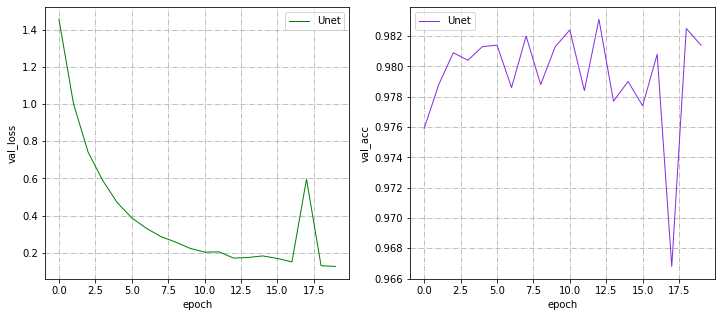

In [ ]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

def get_loss_list(model):
    dir = os.path.join('checkpoint', model)
    files = os.listdir(dir)
    sorted(files)

    index =[]
    losses = []
    acc =[]
    for i,x in enumerate(files):
        index.append(i)
        losses.append(float(x.split("-")[2].strip()))
        acc.append(float(x.split("-")[3][:-3].strip()))

    return index, losses,acc



def plot(model1,model2,if_loss=1):

    x1,y1,z1 = get_loss_list(model1)
    x2,y2,z2 = get_loss_list(model2)

    assert  x1 ==x2
   

    if if_loss:
        pic_name = 'loss'
        plt.plot(x1, y1, color='green', label=model1,linewidth=1.0)
        plt.plot(x2, y2, color='red', label=model2,linewidth=1.0)

    else:
        pic_name = 'acc'
        plt.plot(x1, z1, color='blueviolet', label=model1,linewidth=1.0)
        plt.plot(x2, z2, color='chocolate', label=model2,linewidth=1.0)

    plt.grid(linestyle='-.')
    plt.legend() 

    plt.xlabel('epoch')
    plt.ylabel('val_'+pic_name)
    # plt.show()
    plt.savefig(pic_name+'.jpg')


def plot1(model1, name):
    x1, y1, z1 = get_loss_list(model1)
    #x2, y2, z2 = get_loss_list(model2)

    #assert x1 == x2
    
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(1, 2, 1)

    pic_name = 'loss'
    plt.plot(x1, y1, color='green', label=model1, linewidth=1.0)
    #plt.plot(x2, y2, color='red', label=model2, linewidth=1.0)
    plt.grid(linestyle='-.')
    plt.legend()  
    plt.xlabel('epoch')
    plt.ylabel('val_' + pic_name)

    fig.add_subplot(1, 2, 2)
    pic_name = 'acc'
    plt.plot(x1, z1, color='blueviolet', label=model1, linewidth=1.0)
    #plt.plot(x2, z2, color='chocolate', label=model2, linewidth=1.0)
    plt.grid(linestyle='-.')
    plt.legend()  
    plt.xlabel('epoch')
    plt.ylabel('val_' + pic_name)
    # plt.show()
    plt.savefig(name + '.jpg')

if __name__ == '__main__':
    model1 = 'Unet'
    #model2 = ''

    # plot(model1,model2,if_loss=0)

    plot1(model1,'result')

In [ ]:
print(images_path)

Crack_Segmentation_Labelled/test/images/Cracked/


# Testing

In [ ]:
import argparse

import glob, os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras



parser = argparse.ArgumentParser()
parser.add_argument("--save_weights_path", type=str,default='checkpoint/Unet/weights-020-0.1259-0.9814.h5')
parser.add_argument("--test_images", type=str, default='Crack_Segmentation_Labelled/test/images/Cracked/')
parser.add_argument("--output_path", type=str,default='test_result')
parser.add_argument("--img_height", type=int, default=224)
parser.add_argument("--img_width", type=int, default=224)
parser.add_argument("--vis", type=bool, default=True)
parser.add_argument('-f')

args = parser.parse_args()

images_path = args.test_images
img_width =  args.img_width
img_height = args.img_height

batch_size = 4

def output_test_image(x, pr, gt, path):
    fig=plt.figure(figsize=(12, 4))
    fig.add_subplot(1, 3, 1)
    plt.imshow(pr)
    fig.add_subplot(1, 3, 2)
    plt.imshow(x)
    fig.add_subplot(1, 3, 3)
    plt.imshow(gt)
    plt.savefig(path)
    plt.close()


m = Net()
m.compile(loss='binary_crossentropy',optimizer= keras.optimizers.Adam(lr=1e-4),metrics=['accuracy', f1_score])

m.load_weights(args.save_weights_path)
print('loaded: ', args.save_weights_path)

test_images = glob.glob(images_path + '*.jpg')
test_images.sort()
seg_path = "Crack_Segmentation_Labelled/test/masks/Cracked/"
gt_seg = glob.glob(seg_path + '*.jpg')
gt_seg.sort()
print(len(test_images))
print(len(gt_seg))
assert len(test_images) == len(gt_seg)
for im, seg in zip(test_images, gt_seg):
    assert (im.split('/')[-1].split('.')[0] == seg.split('/')[-1].split('.')[0])


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
L_conv1-1 (Conv2D)              (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
bn_L_conv1-1 (BatchNormalizatio (None, 224, 224, 32) 128         L_conv1-1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           bn_L_conv1-1[0][0]               
_______________________________________________________________________________________

In [ ]:
batch_size

32

In [ ]:
!ls Crack500/images

CRACK500_20160222_080850_1281_361.jpg  CRACK500_20160222_080850_641_721.jpg
CRACK500_20160222_080850_1281_721.jpg  CRACK500_20160222_080933_361_1281.jpg
CRACK500_20160222_080850_1_361.jpg     CRACK500_20160222_080933_361_1921.jpg
CRACK500_20160222_080850_1921_1.jpg    CRACK500_20160222_080933_361_641.jpg
CRACK500_20160222_080850_1921_361.jpg  CRACK500_20160222_080933_721_1.jpg
CRACK500_20160222_080850_641_361.jpg   CRACK500_20160222_080933_721_641.jpg


In [ ]:
!ls Rissibilder

images	masks


# Predicting on training data

In [ ]:
#images_path = 'Crack_Segmentation_Labelled/train/images/Cracked/'
#seg_path = 'Crack_Segmentation_Labelled/train/masks/Cracked/'

images_path = 'Crack500/images/'
seg_path = 'Crack500/masks/'

batch_size = 8
m.load_weights(args.save_weights_path)
print('loaded: ', args.save_weights_path)
test_images = glob.glob(images_path + '*.jpg')
test_images.sort()
#seg_path = "Crack_Segmentation_Labelled/test/masks/Cracked/"
gt_seg = glob.glob(seg_path + '*.jpg')
gt_seg.sort()


loaded:  checkpoint/Unet/weights-020-0.1259-0.9814.h5


In [ ]:
len(test_images)

504

In [ ]:
train_gen1 = data_loader.imageSegmentationGenerator(images_path,
               seg_path, batch_size, img_height, img_width, False,phase='test')

pred1 = m.predict(train_gen1, steps=len(test_images)//batch_size,verbose = 1)
#pred1 = np.argmax(pred, axis=-1)
#print(pred1.shape)

63/63 [==============================] - 200s 3s/step


In [ ]:
pred1 = np.argmax(pred1, axis=-1)

In [ ]:
pred1.shape

(504, 224, 224)

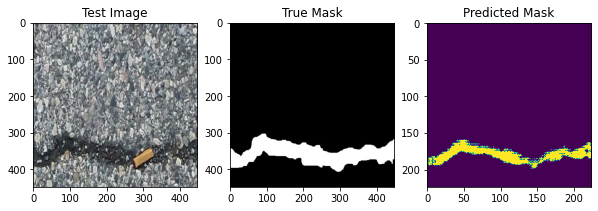

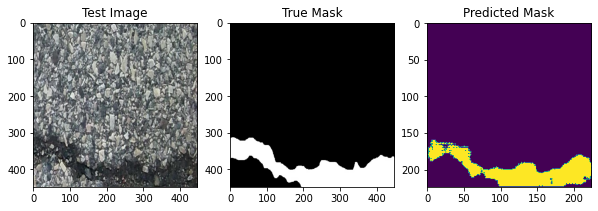

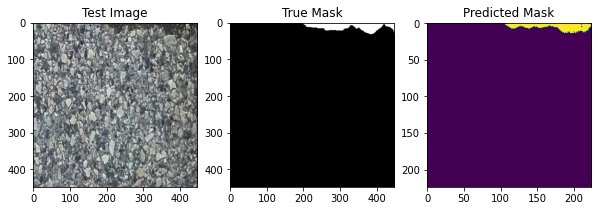

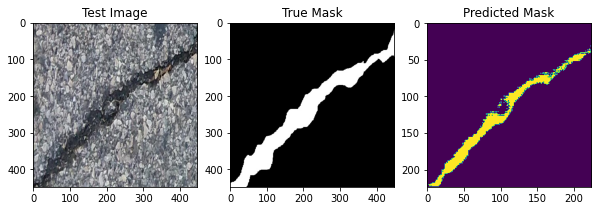

In [ ]:
import matplotlib.pyplot as plt

for i in range(11,15):

  fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
  img = keras.preprocessing.image.load_img(test_images[i])    
  ax1.imshow(img)
  img = keras.preprocessing.image.load_img(gt_seg[i])    
  ax2.imshow(img)
  ax3.imshow(pred1[i])

  ax1.set_title('Test Image')
  ax2.set_title('True Mask')
  ax3.set_title('Predicted Mask')
  plt.show()

In [ ]:
iou_score = 0.0
f1_scores = 0.0
gt = data_loader.getSegmentationArr(gt_seg[1], img_width, img_height)
gt = np.argmax(gt, axis=-1)
pred_label = pred1[1, :, :]
intersection = np.logical_and(gt, pred_label)
union = np.logical_or(gt, pred_label)
iou_score += np.sum(intersection,dtype=np.float) / np.sum(union,dtype=np.float)
f1_scores += f1_score(gt,pred_label)
print(iou_score)
print(f1_scores)

0.4658536585365854
tf.Tensor(0.6356073, shape=(), dtype=float32)


In [ ]:
iou_score = 0.0
f1_scores = 0.0
for idx in range(pred1.shape[0]):
    gt = data_loader.getSegmentationArr(gt_seg[idx], img_width, img_height)
    gt = np.argmax(gt, axis=-1)
    pred_label = pred1[idx, :, :]
    intersection = np.logical_and(gt, pred_label)
    union = np.logical_or(gt, pred_label)
    iou_score += np.sum(intersection,dtype=np.float) / np.sum(union,dtype=np.float)

    f1_scores += f1_score(gt,pred_label)
print(f1_scores)
print(iou_score)
with tf.compat.v1.Session() as sess:
  constant = tf.constant(f1_scores)
  tft = constant
  print('mIOU:' + str(iou_score/pred1.shape[0]), 'f1_score:' + str(tft.eval()/pred1.shape[0]))

tf.Tensor(128.69095, shape=(), dtype=float32)
86.35694204308543
mIOU:0.17134313897437584 f1_score:0.2553391835046193


In [ ]:
test_gen = data_loader.imageSegmentationGenerator(images_path,
               seg_path, batch_size, img_height, img_width, False,phase='test')

pred = m.predict(test_gen, steps=len(test_images)//batch_size, verbose=1)
pred = np.argmax(pred, axis=-1)
print(pred.shape)

370/370 [==============================] - 932s 3s/step
(1480, 224, 224)


In [ ]:
#Visualizing

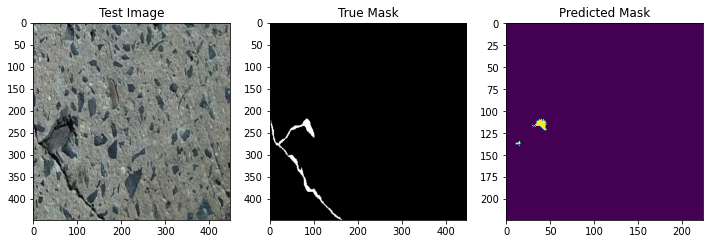

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
i = 40
img = keras.preprocessing.image.load_img(test_images[i])    
ax1.imshow(img)
img = keras.preprocessing.image.load_img(gt_seg[i])    
ax2.imshow(img)
ax3.imshow(pred[i])

ax1.set_title('Test Image')
ax2.set_title('True Mask')
ax3.set_title('Predicted Mask')
plt.show()

In [ ]:
print(pred.shape[2])

224


In [ ]:
print(args.vis)

True


In [ ]:
img_width
img_height

224

In [ ]:
iou_score = 0.0
f1_scores = 0.0
gt = data_loader.getSegmentationArr(gt_seg[100], img_width, img_height)
gt = np.argmax(gt, axis=-1)
pred_label = pred[100, :, :]
intersection = np.logical_and(gt, pred_label)
union = np.logical_or(gt, pred_label)
iou_score += np.sum(intersection,dtype=np.float) / np.sum(union,dtype=np.float)
f1_scores += f1_score(gt,pred_label)
print(iou_score)
print(f1_scores)

0.3380281690140845
tf.Tensor(0.5052631, shape=(), dtype=float32)


In [ ]:
iou_score = 0.0
f1_scores = 0.0
for idx in range(pred.shape[0]):
    gt = data_loader.getSegmentationArr(gt_seg[idx], img_width, img_height)
    gt = np.argmax(gt, axis=-1)
    pred_label = pred[idx, :, :]
    intersection = np.logical_and(gt, pred_label)
    union = np.logical_or(gt, pred_label)
    iou_score += np.sum(intersection,dtype=np.float) / np.sum(union,dtype=np.float)

    f1_scores += f1_score(gt,pred_label)
print(f1_scores)
print(iou_score)


NameError: ignored

mIOU:nan f1_score:0.14327187409272066


KeyboardInterrupt: ignored

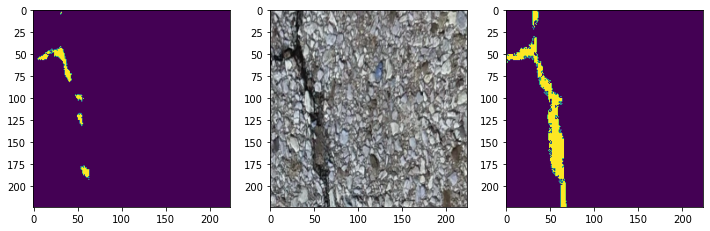

In [ ]:
with tf.compat.v1.Session() as sess:
  tft = tf.constant(f1_scores)
  #tft = constant*constant
  print('mIOU:' + str(iou_score/pred.shape[0]), 'f1_score:' + str(tft.eval()/pred.shape[0]))

if args.vis:
    output_path = args.save_weights_path.split('/')[1]+'_predict/'
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    for i, imgName in enumerate(test_images):

        outName = os.path.join(output_path,os.path.basename(imgName))

        X,gt = data_loader.getImageArr(imgName, gt_seg[i], img_width, img_height,False)# phase='test')
        pr = pred[i, :,:]
        gt = np.argmax(gt, axis=-1)
        output_test_image(X, pr, gt, outName)